In [102]:
import numpy as np
from scipy.optimize import fsolve, minimize_scalar

import matplotlib.pyplot as plt
%matplotlib inline  

# Rocket Engine Thrust

In [103]:
# https://www.grc.nasa.gov/www/k-12/airplane/rktthsum.html


p_t = 60. * 10**5   # pressure in tank [Pa]
T_t = 300.          # temperature in tank [K]
d_star = .02        # diameter at throat [m]
d_e = .25           # diameter at exit [m]


gam = 1.4           # specific heat ratio for oxygen
R = 287.058         # specific gas constant for oxygen [J/kg/K]
p_0 = 862.          # vacuum tube pressure [Pa]


def computeThrust(p_t, T_t, d_star, d_e, debug=False):
    A_e = np.pi * (d_e/2.)**2.
    A_star = np.pi * (d_star/2.)**2.
    
    m_dot = (A_star * p_t / np.sqrt(T_t)) * np.sqrt(gam/R) * ((gam+1.)/2.)**(-((gam+1.)/(gam-1.)/2.))
    M_e = fsolve(
        lambda M: (((gam+1.)/2.)**(-((gam+1.)/(gam-1.)/2))) / M * (1. + M**2. * (gam-1.)/2.)**((gam+1.)/(gam-1.)/2.) - A_e/A_star
        , 100.)[0]
    p_e = p_t * (1. + M_e**2. * (gam-1.)/2.)**(-(gam/(gam-1.)))
    T_e = T_t / (1. + M_e**2. * (gam-1.)/2.)
    v_e = M_e * np.sqrt(gam * R * T_e)
    F = m_dot * v_e + (p_e - p_0) * A_e

    if debug:
        print """
        Thrust: {} [kN]
        m_dot:  {} [kg/s]
        v_e:    {} [m/s]
        M_e:    {} 
        p_e:    {} [Pa]
        T_e:    {} [K]
        """.format(F/1000., m_dot, v_e, M_e, p_e, T_e)

        print """
        m_dot * v_e:       {} [kN]
        (p_e - p_0) * A_e: {} [kN]
        """.format(m_dot * v_e/1000., (p_e - p_0) * A_e/1000.)

        print """
        A_e:    {} [cm2]
        A_star: {} [cm2]
        """.format(A_e*10000, A_star*10000)
    
    return F

computeThrust(p_t, T_t, d_star, d_e, True)


        Thrust: 3.27567332463 [kN]
        m_dot:  4.39820986247 [kg/s]
        v_e:    745.32696491 [m/s]
        M_e:    7.66227237824 
        p_e:    812.474379674 [Pa]
        T_e:    23.5440301151 [K]
        

        m_dot * v_e:       3.27810440783 [kN]
        (p_e - p_0) * A_e: -0.0024310832028 [kN]
        

        A_e:    490.873852123 [cm2]
        A_star: 3.14159265359 [cm2]
        


3275.673324627915

Optimal d_e: 0.244861204375 [m] at 3.27572361467 [kN]


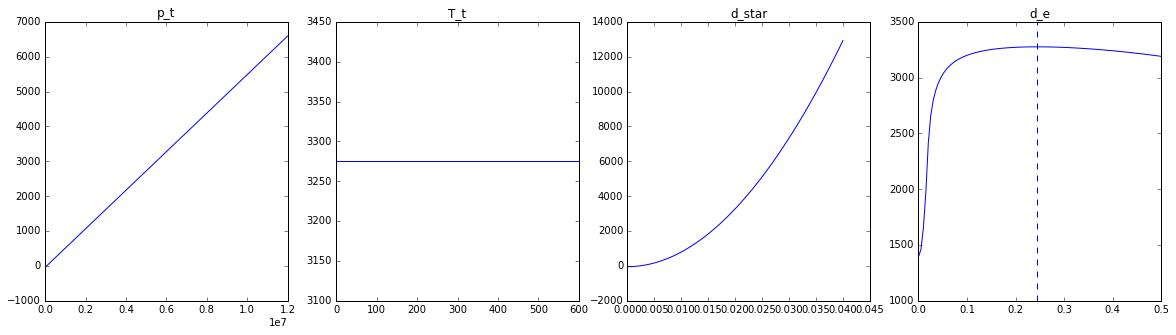

In [8]:
# Visualize Thrust vs [ p_t, T_t, d_star, d_e ]

# Actual value in center of the x-axis

plt.rcParams['figure.figsize'] = (20, 5)
thrust = np.vectorize(computeThrust)

f, ax = plt.subplots(1,4)

p = np.linspace(0.,2.*p_t,100)
ax[0].set_title('p_t')
ax[0].plot(p, thrust(p, T_t, d_star, d_e))

T = np.linspace(1.,2.*T_t,100)
ax[1].set_title('T_t')
ax[1].plot(T, thrust(p_t, T, d_star, d_e))

d = np.linspace(0.0001,2.*d_star,100)
ax[2].set_title('d_star')
ax[2].plot(d, thrust(p_t, T_t, d, d_e))


d = np.linspace(0.0001,2.*d_e,100)

d_e_opt = minimize_scalar(lambda d: -computeThrust(p_t, T_t, d_star, d), bounds=(.1, 1.), method='bounded').x
print "Optimal d_e: {} [m] at {} [kN]".format(d_e_opt, computeThrust(p_t, T_t, d_star, d_e_opt)/1000.)

ax[3].set_title('d_e')
ax[3].plot(d, thrust(p_t, T_t, d_star, d))
ax[3].axvline(d_e_opt, linestyle='dashed')

# (Choked) Compressible Flow Through a Valve

In [130]:
# https://www.grc.nasa.gov/www/k-12/airplane/mflchk.html

p_e = 70. * 10**5     # pressure on emitter side [Pa]
p_r = 60. * 10**5     # pressure on receiver side [Pa]
T_e = 300.            # emmiter temperature [K]
d_star = 0.0226       # valve diameter [m] (3/4" NPT -> 0.0226)

def computeFlow(p_e, p_r, T_e, d_star, debug=False):
    A = np.pi*(d_star/2.)**2
    M = np.sqrt(2./(gam-1.) * ((p_e/p_r)**((gam-1.)/gam) - 1.))
    if M > 1.:
        if debug:
            print "M: {}, choked flow!".format(M)
        M = 1.

    m_dot = p_e * M * A * np.sqrt(gam/R/T_e) * (1 + (gam-1.)/2. * M**2.)**((gam+1.)/2./(1.-gam))
    
    if debug:
        print "m_dot: {} [kg/s]".format(m_dot)
    
    return m_dot
    
computeFlow(p_e, p_r, T_e, d_star, debug=True)

m_dot: 4.70720992283 [kg/s]


4.7072099228260846

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


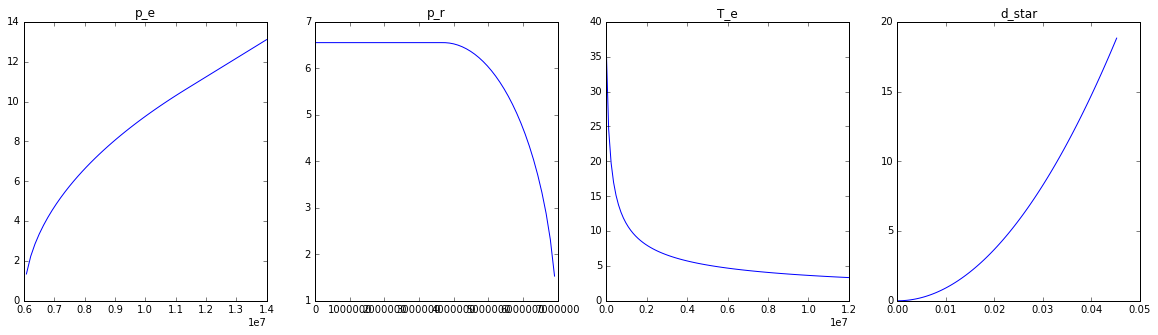

In [131]:
# Visualize Flow vs [ p_e, p_r, T_e, d_star ]

flow = np.vectorize(computeFlow)
plt.rcParams['figure.figsize'] = (20, 5)

f, ax = plt.subplots(1,4)

p = np.linspace(0.,2.*p_e,100)
ax[0].set_title('p_e')
ax[0].plot(p, flow(p, p_r, T_e, d_star))

p = np.linspace(0.01,2.*p_r,100)
ax[1].set_title('p_r')
ax[1].plot(p, flow(p_e, p, T_e, d_star))

T = np.linspace(5.,2.*T_e,100)
ax[2].set_title('T_e')
ax[2].plot(p, flow(p_e, p_r, T, d_star))

d = np.linspace(0.,2.*d_star,100)
ax[3].set_title('d_star')
ax[3].plot(d, flow(p_e, p_r, T_e, d))
